<a href="https://colab.research.google.com/github/sam-vermeulen/MATH4600-Research-Project/blob/main/FastConnectFour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import jax

import numpy as np
import functools

import time

import matplotlib.pyplot as plt

jnp.set_printoptions(precision=100, linewidth=100000)
jax.config.update("jax_enable_x64", True)

# Connect Four

The code for this environment is an adaptation of the implementations by Pascal Pon (http://blog.gamesolver.org/) and John Tromp (https://tromp.github.io/c4/c4.html)

In [2]:
# a game is represented by the following bitmap

# .  .  .  .  .  .  .
# 5 12 19 26 33 40 47
# 4 11 18 25 32 39 46
# 3 10 17 24 31 38 45
# 2  9 16 23 30 37 44
# 1  8 15 22 29 36 43
# 0  7 14 21 28 35 42
#
# The 'position' variable stores the position of the CURRENT PLAYERS pieces
# The 'mask' variable stores the position of all pieces on the board

# IMPORTANT: The position is from only the CURRENT PLAYERS perspective.
# To get the other players we do: position XOR mask

# Assumption: We assume that red plays on even moves, and black plays on odd moves
#               To check parity, we look at the right most bit on the move count (corresponding to 2^0 = 1)
#               eg. move&1 = 1 if move is odd, move&1 = 0 if move is even

# Remark: If the player makes an illegal move, we ignore the move and go to the next players turn
#         (It would be better to let the player redo the action) for now just ensure that our AI's
#         do not make illegal moves..

default_config = {'height' : 6, 'width' : 7}

def init_game(games_shape=1, config=default_config):
  '''initializes the game state tuple to the start of the game'''
  # Rmk: games_shape can be a number with the amount of games you want
  #       OR you can specify a shape tuple. eg. 10000, (1000, 10), and (10, 10, 10, 10) are all valid

  position = jnp.expand_dims(jnp.zeros(games_shape, dtype = jnp.uint64), axis=-1)
  mask = jnp.expand_dims(jnp.zeros(games_shape, dtype = jnp.uint64), axis=-1)
  active = jnp.expand_dims(jnp.ones(games_shape, dtype = jnp.uint64), axis=-1)
  count = 0

  return (position, mask, active, count)

@jax.jit
def get_column_list(config=default_config):
  return jnp.linspace(0, config['width'] - 1, config['width'], dtype=jnp.uint64)

@jax.jit
def get_board_mask(config=default_config):
  '''get a bitmask with all bits on'''
  return (1 << (config['height'] + 1) * config['width']) - 1

@jax.jit
def top_mask(col, config=default_config):
  '''get a bitmask with a 1 at the top of given column'''
  return (1 << (config['height'] - 1)) << (col * (config['height'] + 1))

@jax.jit
def bottom_mask(col, config=default_config):
  '''get a bitmask with a 1 at the bottom of the given column'''
  return 1 << col * (config['height'] + 1)

@jax.jit
def column_mask(col, config=default_config):
  '''get a bitmask with the bits of the given column on'''
  return ((1 << config['height']) - 1) << (col * (config['height'] + 1))

@jax.jit
def can_play(state, col, config=default_config):
  '''check if we can play in the given column'''
  _, mask, _, _ = state

  return (mask & top_mask(col, config)) == 0

@jax.jit
def alignment(state, config=default_config):
  '''checks if there is an alignment for the current player'''
  position, mask, active, count = state

  m = position & (position >> (config['height'] + 1))
  horizontal = jnp.where(m & (m >> (2 * (config['height'] + 1))), 1, 0)

  m = position & (position >> config['height'])
  diag_a = jnp.where(m & (m >> (2 * config['height'])), 1, 0)

  m = position & (position >> (config['height'] + 2))
  diag_b = jnp.where(m & (m >> (2 * (config['height'] + 2))), 1, 0)

  m = position & position >> 1
  vertical = jnp.where(m & (m >> 2), 1, 0)
  
  alignment = horizontal | diag_a | diag_b | vertical
  
  return alignment

@jax.jit
def get_legal_cols(state, config=default_config):
  legal_cols = can_play(state, get_column_list(), config)
  return legal_cols

@jax.jit
def get_opponent_state(state):
  '''gets the bitboard from the opponents perspective'''
  position, mask, active, count = state

  opponent_state = (position ^ mask, mask, active, count)
  return opponent_state

@jax.jit
def update_active_games(state, config=default_config):
  '''checks if the given game is still active and updates the active array'''
  position, mask, active, count = state

  opponent_state = get_opponent_state(state)
  active = 1 - (alignment(opponent_state, config) | alignment(state, config) | (count >= 41))

  return (position, mask, active, count)

@jax.jit
def play_move(state, col, config=default_config):
  '''plays a move in the given column'''
  # note: this switches the players perspective then adds the bitmask
  #       with only an active bit at the bottom of the chosen column to
  #       the 'mask' bitmask this shifts all the bits in that column left by 1.
  position, mask, active, count = state

  position = position ^ mask
  legal = can_play(state, col, config) & active

  new_mask = mask | (mask + bottom_mask(col.astype(jnp.uint64), config))
  mask = jnp.where(legal, new_mask, mask)

  state = (position, mask, active, count)
  _, _, active, _ = update_active_games(state, config)

  count = count + 1

  return (position, mask, active, count)

@jax.jit
def get_winners(state, config=default_config):
  '''gets the winners of the current board'''
  # -1 if red wins
  #  1 if black wins
  # if there are two winners we get 0 (covers invalid game)
  # if there are no winners we get 0 (covers tie/game not over)
  position, mask, active, count = state
  opponent_state = get_opponent_state(state)

  current_alignments = alignment(state)
  opponent_alignments = alignment(opponent_state) * (-1)

  whos_turn = count & 1
  win_value = 2 * whos_turn.astype(jnp.int32) - 1 # -1 if red win, 1 is black win

  # score will be -1 if red has alignment, 1 if black has alignment, 0 if tied, 0 if both have alignments (invalid game)
  total_score = current_alignments * win_value + opponent_alignments * win_value

  return total_score

@jax.jit
def get_winning_columns(state, config=default_config):
  '''gets the first columns that would make the current player win immediately'''
  # -1 if there are no winning columns

  col_masks = column_mask(get_column_list())
  win_mask = get_winning_bitmask(state)
  winning_cols = jnp.where(col_masks & win_mask != 0, 1, 0)

  return winning_cols

@jax.jit
def get_threatening_columns(state, config=default_config):
  '''gets the first column that would make the current player win immediately'''
  opponent_state = get_opponent_state(state)
  return get_winning_columns(opponent_state)

@jax.jit
def get_winning_bitmask(state, config=default_config):
  '''gets a bitmask with 1s in positions that would immediately end the game'''
  pos, mask, _, _ = state

  h = config['height']

  # vertical
  r = (pos << 1) & (pos << 2) & (pos << 3)

  # horizontal
  p = (pos << (h + 1)) & (pos << 2 * (h+1))
  r = r | (p & (pos << 3 * (h + 1)))
  r = r | (p & (pos >> (h + 1)))
  p = p >> (3 * (h + 1))
  r = r | (p & (pos << (h + 1)))
  r = r | (p & (pos >> 3 * (h + 1)))

  # diag 1
  p = (pos << h) & (pos << 2 * h)
  r = r | (p & (pos << 3 * h))
  r = r | (p & (pos >> h))
  p = p >> (3 * h)
  r = r | (p & (pos << h))
  r = r | (p & (pos >> 3 * h))

  # diag 2
  p = (pos << (h + 2)) & (pos << 2 * (h + 2))
  r = r | (p & (pos << 3 * (h + 2)))
  r = r | (p & (pos >> (h + 2)))
  p = p >> (3 * (h + 2))
  r = r | (p & (pos << (h + 2)))
  r = r | (p & (pos >> 3 * (h + 2)))

  return r & ((1 << get_board_mask(config)) - 1 ^ mask)

@jax.jit
def expand_to_next_states(state, config=default_config):
  '''expands the bitboard to all possible next states'''
  
  position, mask, active, count = state

  p_position = jnp.repeat(jnp.expand_dims(position, -2), 7, axis = -2)
  p_mask = jnp.repeat(jnp.expand_dims(mask, -2), 7, axis = -2)
  p_active = jnp.repeat(jnp.expand_dims(active, -2), 7, axis = -2)

  p_state = (p_position, p_mask, p_active, count)

  action = jnp.linspace(0, config['width'] - 1, config['width'], dtype=jnp.uint64)
  p_state = play_move(p_state, action[:, None], config)

  return p_state

@functools.partial(jax.jit, static_argnums=1)
def repeat_game(state, repeats, config=default_config):
  '''adds axis and repeats the game_state along the axis repeat times'''
  # output shape: (repeats, pre-shape, 1)
  position, mask, active, count = state

  p_position = jnp.repeat(jnp.expand_dims(position, 0), repeats, axis=0)
  p_mask = jnp.repeat(jnp.expand_dims(mask, 0), repeats, axis=0)
  p_active = jnp.repeat(jnp.expand_dims(active, 0), repeats, axis=0)

  p_state = (p_position, p_mask, p_active, count)

  return p_state

def to_array(game_state, game_num, config=default_config):
    position, mask, active, count = game_state

    board_size = (config['height']+1) * config['width']
    pieces = np.reshape(2 << (np.array(np.linspace(0, board_size - 1, board_size), dtype=np.uint64) - 1), (config['height'] + 1, config['width'])).T
    pieces[0][0] = 1
    pieces = np.flip(pieces, 0)

    current_player = np.where(pieces & position[game_num] != 0, 1 + (count&1), 0)
    other_player = np.where(pieces & (position ^ mask)[game_num] != 0, 2 - (count&1), 0)
    
    return current_player + other_player

def draw_game(game_state, game_num = 0, player_color = ['red','black'], config=default_config):
  '''Use matplotlib to draw the board in text given the bitboards for player 1 and player 2'''
  
  position, mask, active, count = game_state

  fig, ax = plt.subplots() 
  plt.xlim(-0.5, config['width'] - 0.5)
  plt.ylim(config['height']+0.5, 0.5)
  ax.patch.set_facecolor('lightgrey')

  game_array = to_array(game_state, game_num)

  for y in range(1, config['height']+1):
    for x in range(config['width']):
      outline = plt.Circle((x,y), 0.45, color='white')
      ax.add_patch(outline)

      if game_array[y, x] > 0:
        piece = plt.Circle((x, y), 0.45, color=player_color[game_array[y, x] - 1])
        ax.add_patch(piece)
        

  plt.show()

# Bandits

In [ ]:
class Bandit():
  @functools.partial(jax.jit, static_argnums=0)
  def __init__(self, time, batch_size=10):
    self.time = time
    self.batch_size = batch_size

  @functools.partial(jax.jit, static_argnums=0)
  def choice(self, board, key):
    pass

class EpsilonGreedyBandit(Bandit):
  @functools.partial(jax.jit, static_argnums=0)
  def __init__(self, time, batch_size=10):
    super().__init__(time, batch_size)

  @functools.partial(jax.jit, static_argnums=0)
  def choice(self, board, key):
    legal_moves = board.get_legal_moves()
    print(legal_moves)

    for t in jnp.arange(self.time):
      print(f'time : {t} ')

class UCBBandit(Bandit):
  @functools.partial(jax.jit, static_argnums=0)
  def __init__(self, time, batch_size=10):
    super().__init__(time, batch_size)

  @functools.partial(jax.jit, static_argnums=0)
  def choice(self, board, key):
    legal_moves = board.get_legal_moves()

    for t in jnp.arange(self.time):
      print(f'time : {t} ')

# Agents

In [3]:
class Agent():
  def __init__(self, config=default_config):
    self.config = config

  def choose(self, state, key=None):
    pass

class RandomAgent(Agent):
  def __init__(self, config=default_config):
    super().__init__(config=config)

  def choose(self, state, key=None):
    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    scores = jax.random.uniform(key, shape=(*state[0].shape[:-1], self.config['width']))
    legal_cols = get_legal_cols(state)
    legal_scores = jnp.where(legal_cols, scores, jnp.nan)

    return jnp.nanargmax(legal_scores, axis=-1)[..., None]

class RandomPlusAgent(Agent):
  def __init__(self, config=default_config):
    super().__init__(config=config)

  def choose(self, state, key=None):
    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    random_scores = jax.random.uniform(key, shape=(*state[0].shape[:-1], self.config['width']))
    threats = get_threatening_columns(state, self.config)
    wins = get_winning_columns(state, self.config)

    adjusted_scores = 100*wins + 10*threats + random_scores
    legal_scores = jnp.where(get_legal_cols(state), adjusted_scores, jnp.nan)

    return jnp.nanargmax(legal_scores, axis=-1)[..., None]

class RolloutAgent(Agent):
  def __init__(self, config=default_config, n_rollouts=100):
    super().__init__()
    self.n_rollouts = n_rollouts
    self.agents = [RandomAgent(config), RandomAgent(config)]

  def choose(self, state, key=None):
    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    # expand our game state over all possible states
    n_states = expand_to_next_states(state)

    # repeat these states for n_rollouts
    np_states = repeat_game(n_states, self.n_rollouts)

    # run all games to the end
    sim = Simulator(np_states, self.agents, key)
    results = sim.run()
    
    # calculate the scores
    mean_scores = jnp.squeeze(jnp.mean(results, axis=0))
    legal_scores = jnp.where(get_legal_cols(state), mean_scores, jnp.nan)

    return np.nanargmax(legal_scores * (2*(state[3]&1) - 1), axis=-1)[..., None]

class UCBRolloutsAgent(Agent):
  def __init__(self, time=20, rollouts_per_t=10, confidence_level=1, config=default_config):
    super().__init__()

    self.time = time
    self.rollouts_per_t = rollouts_per_t
    self.confidence_level = confidence_level
    self.config = config

  def calc_ucb(self, initial_values, action_count, t):
    return initial_values + self.confidence_level * jnp.sqrt(jnp.log(t) / action_count)

  def do_batch_rollout(self, state, key=None):
    position, mask, active, move = state

    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    p_state = repeat_game(state, self.rollouts_per_t)
    agents = [RandomAgent(self.config), RandomAgent(self.config)]

    sim = Simulator(p_state, agents, key)
    return sim.run()

  def choose(self, state, key=None):
    position, mask, active, move = state

    n_actions = self.config['width']
    win_counts = jnp.ones((*state[0].shape[:-1], n_actions, 1), dtype=jnp.uint64)
    # (pre-shape, 7)
    action_counts = jnp.ones_like(win_counts, dtype=jnp.uint64)
    # (pre-shape, 7)
    legal_actions = get_legal_cols(state)[..., None]

    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    key, subkey = jax.random.split(key)

    agent = RolloutAgent(self.config, n_rollouts=self.rollouts_per_t)
    actions = agent.choose(state, subkey)

    player = (move)&1
    for t in jnp.arange(self.time):
      key, subkey = jax.random.split(key)

      n_states = play_move(state, actions.astype(jnp.uint64))
      results = self.do_batch_rollout(n_states, subkey)
      one_hot_actions = jnp.squeeze(jax.nn.one_hot(actions, num_classes = n_actions))
      win_counts = win_counts + (one_hot_actions * jnp.count_nonzero(results == 2*player - 1, axis=0))[..., None]
      action_counts = action_counts + self.rollouts_per_t * one_hot_actions[..., None]

      ucb = self.calc_ucb(win_counts/action_counts,action_counts, t*self.rollouts_per_t)
      legal_ucb = jnp.where(legal_actions, ucb, jnp.nan)
      actions = jnp.nanargmax(legal_ucb, axis=-2)

    ucb = self.calc_ucb(win_counts/action_counts,action_counts, (t+1)*self.rollouts_per_t)
    legal_ucb = jnp.where(legal_actions, ucb, jnp.nan)

    return jnp.nanargmax(legal_ucb, axis=-2)

class PlayerAgent(Agent):
  #NOTE: this only works when game_shape=1
  def __init__(self, config=default_config):
    super().__init__()

    self.config = config

  def choose(self, state, key=None):
    draw_game(state)
    print("Which column would you like to play in")
    raw_input = input()
    choice = np.clip(int(raw_input), 0, self.config['width'])
    return choice

# Simulator

In [4]:
class Simulator():
  '''simulates game to end from a state with given AIs'''

  def __init__(self, game_state, agents, key=None, config=default_config):
    self.agents = agents
    self.game_state = game_state
    self.config = config

    if key == None:
      self.key = jax.random.PRNGKey(int(time.time()))
    else:
      self.key = key

  def step(self, verbose=False):
    self.key, subkey = jax.random.split(self.key)
    choices = self.agents[self.game_state[3]&1].choose(self.game_state, subkey)

    self.game_state = play_move(self.game_state, choices.astype(jnp.uint64))

  def run(self, verbose=False):
    # games should only take 42 moves if all are legal.
    for i in jnp.arange(42):
      self.key, subkey = jax.random.split(self.key)

      if verbose:
        print(f'move # {i+1}')

      choices = self.agents[i&1].choose(self.game_state, subkey)

      if verbose:
        print(jnp.squeeze(choices))

      self.game_state = play_move(self.game_state, choices.astype(jnp.uint64))

    return get_winners(self.game_state, self.config)

In [ ]:
#sim = Simulator(init_game(1), [PlayerAgent(), UCBRolloutsAgent(time=20, rollouts_per_t=100, confidence_level=0.6)])
sim = Simulator(init_game(100), [RandomPlusAgent(), RolloutAgent(n_rollouts=1000)])
jnp.mean(sim.run())

In [ ]:
sim = Simulator(init_game(50), [UCBRolloutsAgent(time=50, rollouts_per_t=5, confidence_level=0.4), RandomPlusAgent()])
%time jnp.mean(sim.run())

CPU times: user 1min 53s, sys: 27.3 s, total: 2min 20s
Wall time: 1min 45s


DeviceArray(-0.96, dtype=float32)

In [ ]:
sim = Simulator(init_game(50), [RolloutAgent(n_rollouts=200), RandomPlusAgent()])
%time jnp.mean(sim.run())

CPU times: user 3.35 s, sys: 619 ms, total: 3.97 s
Wall time: 3.96 s


DeviceArray(-1., dtype=float32)

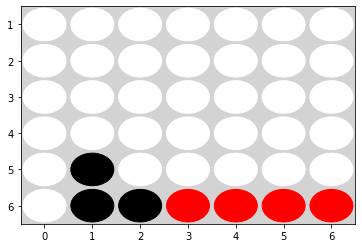

In [ ]:
state = sim.game_state
draw_game(state, 998)

In [ ]:
sim = Simulator(init_game(10_000_000), [RandomAgent(), RandomAgent()])
%time jnp.mean(sim.run())

CPU times: user 2.99 s, sys: 41.8 ms, total: 3.03 s
Wall time: 2.98 s


DeviceArray(-0.114560105, dtype=float32)

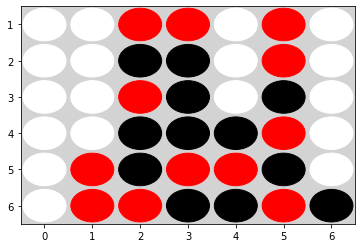

In [ ]:
state = sim.game_state
draw_game(state, 2)

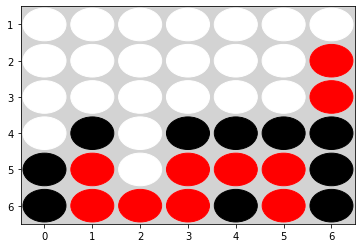

In [ ]:
state = sim.game_state
draw_game(state, 1)